# Filtrage collaboratif avec Implicit
On va utiliser la version qui travaille avec le GPU

In [1]:
! nvidia-smi

Fri Apr 25 11:29:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   36C    P8              2W /   80W |      94MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Données

### Chargement du dataframe global

In [2]:
import pandas as pd

df_clicks = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [3]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


### Liste des articles

In [4]:
df_articles = pd.read_csv("./data/articles_with_popularity.csv", encoding='utf-8')
df_articles

,article_id,category_id,created_at_ts,publisher_id,words_count,cluster,publish_time_dt,nb_clics,popularite_tag,popularity_norm
0,0,0,1513144419000,0,168,16,2017-12-13 05:53:39,0,jamais_cliqué,0.000000
1,1,1,1405341936000,0,189,11,2014-07-14 12:45:36,0,jamais_cliqué,0.000000
2,2,1,1408667706000,0,250,3,2014-08-22 00:35:06,0,jamais_cliqué,0.000000
3,3,1,1408468313000,0,230,3,2014-08-19 17:11:53,1,banal,0.000027
4,4,1,1407071171000,0,162,3,2014-08-03 13:06:11,0,jamais_cliqué,0.000000
...,...,...,...,...,...,...,...,...,...,...
364042,364042,460,1434034118000,0,144,2,2015-06-11 14:48:38,0,jamais_cliqué,0.000000
364043,364043,460,1434148472000,0,463,7,2015-06-12 22:34:32,8,banal,0.000215
364044,364044,460,1457974279000,0,177,6,2016-03-14 16:51:19,0,jamais_cliqué,0.000000
364045,364045,460,1515964737000,0,126,1,2018-01-14 21:18:57,0,jamais_cliqué,0.000000


### Chargement des embeddings réduits

In [5]:
import pandas as pd

embeddings_df = pd.read_parquet('./data/articles_embeddings_pca.parquet')
print(embeddings_df.shape)

(364047, 41)


In [6]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
0,-1.854453,-5.592402,1.708724,-3.835164,1.415795,0.252210,0.426074,0.545480,-0.807394,1.520171,...,0.387738,-0.088799,0.990514,1.060148,-0.218378,-1.099852,-1.175524,1.370632,-0.264816,0.010117
1,-5.361997,4.122991,-2.357516,-3.428017,-0.431079,3.722260,2.389835,-1.267244,1.944162,2.980629,...,0.025565,-0.721510,0.649929,-0.405225,-0.090690,-3.094968,0.075186,0.245235,-1.250343,0.294538
2,-3.600085,-0.132112,-6.027451,0.985617,0.211965,4.591712,-1.815688,-2.170389,-2.783090,2.804910,...,0.565647,-1.862223,-0.336458,0.072410,0.241466,-0.877634,0.154883,1.133963,0.946740,-1.811314
3,-1.158963,7.293352,-5.916713,-1.370524,2.172241,-1.682487,1.070822,-2.160001,1.947324,4.069597,...,0.074049,-0.612824,-1.511408,1.071736,1.991838,-2.076190,-1.690459,-1.122692,0.714619,-1.576244
4,-1.142884,2.569328,-2.891860,-0.273997,2.913007,5.608970,0.308953,0.310888,-1.054171,2.158180,...,-1.527867,-0.155615,-0.163345,0.037253,1.173636,-4.232923,-1.287476,1.053438,-0.486085,-0.144550


In [7]:
# conversion des embeddings en tableau NumPy (évite de calculer la matrice de similarité complète)
import numpy as np
article_ids = embeddings_df.index.to_numpy()
article_embeddings = embeddings_df.to_numpy()

# dictionnaire article_id -> vecteur
embedding_dict = dict(zip(article_ids, article_embeddings))

## Préparation des données pour Implicit

### Filtrage des utilisateurs
On va se limiter aux utilisateurs ayant effectué plus de 2 clics, implicit a besoin d'un minimum d'interaction pour apprendre et il est contre-productif de rajouter de la sparsité à la matrice item-user

In [8]:
user_article_clicks = df_clicks.groupby(['user_id', 'click_article_id']).size().reset_index(name='click_count')
# Filtrage des utilisateurs
articles_per_user = user_article_clicks.groupby('user_id')['click_article_id'].nunique()
filtered_users = articles_per_user[articles_per_user >= 3].index
# Application du filtre
df = user_article_clicks[user_article_clicks['user_id'].isin(filtered_users)]

### Création de la matrice item-user
On a simplement ignoré les articles non cliqués.

In [9]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np

def build_item_user_matrix(df_clicks, weighting="log", alpha=40.0):
    """
    Construit une matrice CSR (articles × utilisateurs) compatible avec implicit,
    avec un remapping sécurisé et une pondération logarithmique ou linéaire.

    Paramètres :
    - df_clicks : DataFrame contenant 'user_id' et 'click_article_id'
    - weighting : 'log' (default) ou 'linear'
    - alpha : coefficient multiplicateur pour la pondération log

    Retourne :
    - item_user_matrix : matrice CSR (n_items x n_users)
    - user_mapping : dict {user_id → user_idx}
    - item_mapping : dict {click_article_id → item_idx}
    """

    # Agrégation des interactions
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # Création des mappings
    print("🔄 Construction des dictionnaires d’indexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="🔢 Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="🧾 Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    # Pondération
    if weighting == "log":
        df_user_item['weight'] = 1.0 + alpha * np.log1p(df_user_item['click_strength'])
        print(f"🧮 Pondération logarithmique avec alpha={alpha}")
    elif weighting == "linear":
        df_user_item['weight'] = df_user_item['click_strength'].astype(float)
        print("🧮 Pondération linéaire")
    else:
        raise ValueError("Le paramètre 'weighting' doit être 'log' ou 'linear'.")

    # Construction de la matrice sparse
    print("📐 Construction de la matrice sparse (CSR)...")
    item_user_matrix = coo_matrix(
        (df_user_item['weight'],
         (df_user_item['item_idx'], df_user_item['user_idx']))
    ).tocsr()

    print(f"✅ Matrice prête : {item_user_matrix.shape} (articles × utilisateurs)")
    return item_user_matrix, user_mapping, item_mapping


In [10]:
item_user_matrix, user_mapping, item_mapping = build_item_user_matrix(df)


🔄 Construction des dictionnaires d’indexation...


🧾 Mapping articles: 100%|██████████| 41367/41367 [00:00<00:00, 4343508.08it/s]


🧮 Pondération logarithmique avec alpha=40.0
📐 Construction de la matrice sparse (CSR)...
✅ Matrice prête : (41367, 221379) (articles × utilisateurs)


In [11]:
# 🔄 Construction du reverse mapping des articles
# Rappel : item_mapping = {article_id: item_idx}
reverse_item_mapping = {idx: aid for aid, idx in item_mapping.items()}

### Visualisation de la matrice item-user

In [12]:
import matplotlib.pyplot as plt

def plot_sparse_matrix_density(sparse_matrix, title="Matrice sparse (articles × utilisateurs)"):
    plt.figure(figsize=(10, 6))
    plt.spy(sparse_matrix, markersize=0.5)
    plt.title(title)
    plt.xlabel("Utilisateurs")
    plt.ylabel("Articles")
    plt.grid(True)
    plt.show()


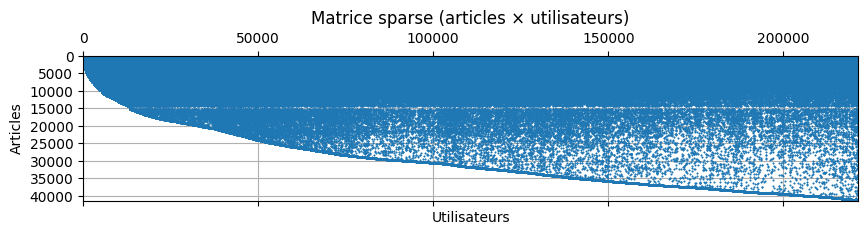

In [13]:
plot_sparse_matrix_density(item_user_matrix)

<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>Explication :</strong> La répartition des données dans la matrice reflète le fait que l'on a enregistré les clics selon le temps, les utilisateurs et les articles s'accumulent petit à petit (pas de shuffle lors du mappage des index)
</div>

In [14]:
def print_matrix_density(sparse_matrix):
    n_total = sparse_matrix.shape[0] * sparse_matrix.shape[1]
    n_nonzero = sparse_matrix.nnz
    density = n_nonzero / n_total * 100

    print(f"📦 Taux de remplissage : {n_nonzero:,} éléments non nuls")
    print(f"📐 Dimensions         : {sparse_matrix.shape}")
    print(f"📊 Densité            : {density:.6f}%")

In [15]:
print_matrix_density(item_user_matrix)

📦 Taux de remplissage : 2,747,674 éléments non nuls
📐 Dimensions         : (41367, 221379)
📊 Densité            : 0.030004%


## Mise en oeuvre du modèle ALS (Alternative Least Squares)

In [16]:
import time
from implicit.gpu.als import AlternatingLeastSquares

# Paramètres
factors = 64
iterations = 15
regularization = 0.1

# Modèle ALS GPU
model = AlternatingLeastSquares(
    factors=factors,
    regularization=regularization,
    iterations=iterations
)

# Entraînement
print("⏱️ Entraînement ALS en cours...")
start = time.time()
model.fit(item_user_matrix)
end = time.time()
print(f"✅ Modèle entraîné en {end - start:.2f} secondes")


⏱️ Entraînement ALS en cours...


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 15/15 [00:01<00:00, 13.78it/s]

✅ Modèle entraîné en 1.20 secondes


### 💡 Vérification rapide du traitement après entrainement-test

In [17]:
def get_recommendations_for_user(
    user_id,
    model,
    item_user_matrix,
    user_mapping,
    reverse_item_mapping,
    df_clicks,
    N=5
):
    """
    Renvoie les recommandations d'articles pour un utilisateur donné.

    Paramètres :
    - user_id : identifiant de l'utilisateur (origine des données)
    - model : modèle ALS entraîné (implicit.gpu ou cpu)
    - item_user_matrix : matrice CSR article x utilisateur
    - user_mapping : dict {user_id → user_idx}
    - reverse_item_mapping : dict {item_idx → click_article_id}
    - df_clicks : DataFrame original pour extraire les clics réels
    - N : nombre de recommandations à retourner

    Retourne :
    - clicked_article_ids : liste des articles réellement cliqués
    - recommended_articles : liste de tuples (click_article_id, score)
    """

    # Vérifie que l'utilisateur est connu
    if user_id not in user_mapping:
        raise ValueError(f"L'utilisateur {user_id} n'est pas présent dans le mapping.")

    user_idx = user_mapping[user_id]

    # Extraire les articles cliqués
    clicked_article_ids = df_clicks[df_clicks['user_id'] == user_id]['click_article_id'].unique().tolist()

    # Extraire une ligne CSR (1, n_items)
    user_items = item_user_matrix.T.tocsr()
    user_row = user_items[user_idx:user_idx+1]

    # Recommandations
    recommended = model.recommend(
        userid=user_idx,
        user_items=user_row,
        N=N,
        filter_already_liked_items=True # ❌ on ne filtre pas les clics passés
    )

    # Conversion des item_idx en click_article_id
    recommended_articles = [
        (reverse_item_mapping[int(i)], float(s)) for i, s in zip(*recommended)
        if int(i) in reverse_item_mapping
    ]

    return clicked_article_ids, recommended_articles


In [18]:
clicked, recommended = get_recommendations_for_user(
    user_id=42,
    model=model,
    item_user_matrix=item_user_matrix,
    user_mapping=user_mapping,
    reverse_item_mapping=reverse_item_mapping,
    df_clicks=df,
    N=5
)

print("📌 Articles cliqués :", clicked)
print("⭐ Articles recommandés :", recommended)


📌 Articles cliqués : [9126, 71608, 75825, 107216, 119193, 119534, 129434, 145166, 157861, 158541, 208518, 218028, 225019, 226595, 226648, 235854, 284178, 284346, 285331, 285414, 288457, 292594, 292749, 313996, 315146, 331116, 336220, 336221, 336380, 352902, 353673]
⭐ Articles recommandés : [(np.int32(149661), 0.3780154883861542), (np.int32(60465), 0.3226817846298218), (np.int32(313957), 0.29412543773651123)]


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# df_embeddings doit être un DataFrame avec index = article_id, colonnes = ["dim1", "dim2"]
# clicked_article_ids : liste des articles que l'utilisateur a cliqués
# recommended_articles : liste de tuples (article_id, score)


import matplotlib.pyplot as plt

def plot_article_recommendations(df_embeddings, clicked_article_ids, recommended_articles):
    """
    Affiche une projection 2D des articles, avec les articles recommandés et cliqués mis en valeur.

    Args:
    - df_embeddings: DataFrame avec index = article_id, colonnes = ['dim1', 'dim2']
    - clicked_article_ids: liste d'IDs d'articles cliqués par l'utilisateur
    - recommended_articles: liste de tuples (article_id, score)
    """
    df_visu = df_embeddings.reset_index().copy()

    # Sélection uniquement des articles présents dans la projection
    projected_ids = set(df_visu['article_id'])

    clicked_article_ids = [aid for aid in clicked_article_ids if aid in projected_ids]
    recommended_articles = [(aid, s) for aid, s in recommended_articles if aid in projected_ids]

    # Alerte si des éléments ne sont pas projetés
    if len(clicked_article_ids) == 0:
        print("⚠️ Aucun article cliqué n'est dans la projection.")
    if len(recommended_articles) == 0:
        print("⚠️ Aucun article recommandé n'est dans la projection.")

    # Marquage des statuts
    df_visu['status'] = 'autres'
    df_visu.loc[df_visu['article_id'].isin(clicked_article_ids), 'status'] = 'cliqué'
    for aid, _ in recommended_articles:
        if aid in clicked_article_ids:
            df_visu.loc[df_visu['article_id'] == aid, 'status'] = 'cliqué & recommandé'
        else:
            df_visu.loc[df_visu['article_id'] == aid, 'status'] = 'recommandé'

    # Taille des points via score
    score_dict = {aid: score for aid, score in recommended_articles}
    df_visu['score'] = df_visu['article_id'].map(score_dict)
    df_visu['score'] = df_visu['score'].fillna(0.1)  # visible par défaut

    # Couleurs personnalisées
    palette = {
        'autres': 'lightgray',
        'cliqué': 'blue',
        'recommandé': 'orange',
        'cliqué & recommandé': 'green'
    }

    # Affichage
    plt.figure(figsize=(10, 6))

    # Tracer les "autres" d'abord
    bg = df_visu[df_visu["status"] == "autres"]
    plt.scatter(bg['dim1'], bg['dim2'],
                s=10, c='lightgray', label='autres', alpha=0.3, edgecolors='none')

    # Tracer les autres statuts avec emphase
    for status in ["cliqué", "recommandé", "cliqué & recommandé"]:
        group = df_visu[df_visu["status"] == status]
        if not group.empty:
            plt.scatter(group['dim1'], group['dim2'],
                        s=200 * group['score'],
                        c=palette[status],
                        label=status,
                        alpha=0.9,
                        edgecolors='k',
                        linewidth=0.5,
                        zorder=3)

    plt.title("Projection 2D des articles avec recommandations et clics")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [20]:
# Réduction à 2 dimensions et renommage pour la visualisation
embeddings_df_2d = embeddings_df[[0, 1]].copy()
embeddings_df_2d.columns = ['dim1', 'dim2']
embeddings_df_2d.index.name = 'article_id'


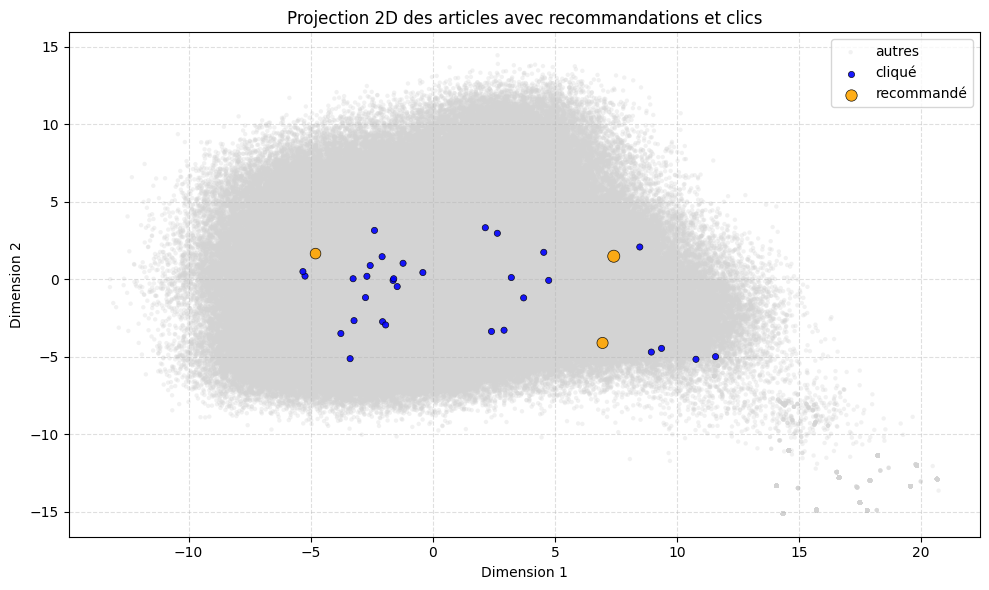

In [21]:
# 📊 Visualisation dans l'espace des embeddings
plot_article_recommendations(
    embeddings_df_2d,             # Ton DataFrame des embeddings 2D (indexé par article_id)
    clicked,       # Liste des articles cliqués par le user
    recommended       # Liste (article_id, score) des recommandations
)

### 🔁 Étape 1 : Split Leave-One-Out

In [22]:
def leave_one_out_split(item_user_matrix):
    """
    Effectue un split leave-one-out par utilisateur sur une matrice (items x users).

    Retourne :
    - train_matrix : matrice CSR (items x users)
    - test_data : liste (user_idx, item_idx)
    """
    user_item_matrix = item_user_matrix.T.tocsr()  # (users, items)
    train_matrix = user_item_matrix.copy().tolil()
    test_data = []

    print("🔄 Création du split leave-one-out...")
    for user_idx in range(user_item_matrix.shape[0]):
        user_items = user_item_matrix[user_idx].indices
        if len(user_items) < 2:
            continue

        test_item = np.random.choice(user_items)
        test_data.append((user_idx, test_item))  # ✅ ordre correct (user_idx, item_idx)
        train_matrix[user_idx, test_item] = 0

    # Transposer pour obtenir (items x users)
    train_matrix = train_matrix.tocsr().T.tocsr()

    print(f"✅ Split terminé : {len(test_data)} interactions mises de côté pour test.")
    return train_matrix, test_data


In [23]:
train_matrix, test_data = leave_one_out_split(item_user_matrix)

🔄 Création du split leave-one-out...
✅ Split terminé : 221379 interactions mises de côté pour test.


In [24]:
print("Taille train_matrix :", train_matrix.shape)
print("Nombre d'utilisateurs dans test_data :", len(set([u for u, _ in test_data])))
print("Nombre d'utilisateurs conservés dans train_matrix :", train_matrix.shape[1])


Taille train_matrix : (41367, 221379)
Nombre d'utilisateurs dans test_data : 221379
Nombre d'utilisateurs conservés dans train_matrix : 221379


In [25]:
print("Max user_idx dans test_data :", max(u for u, _ in test_data))
print("Shape model.user_factors :", model.user_factors.shape)


Max user_idx dans test_data : 221378
Shape model.user_factors : (41367, 64)


In [26]:
print("model.user_factors.shape :", model.user_factors.shape)
print("Expected users :", train_matrix.shape[1])  # doit correspondre
print("Expected items :", train_matrix.shape[0])


model.user_factors.shape : (41367, 64)
Expected users : 221379
Expected items : 41367


In [27]:
print("Exemple test_data :", test_data[:5])
print("Max user_idx :", max(u for u, _ in test_data))
print("Max item_idx :", max(i for _, i in test_data))


Exemple test_data : [(0, np.int32(6)), (1, np.int32(17)), (2, np.int32(22)), (3, np.int32(28)), (4, np.int32(44))]
Max user_idx : 221378
Max item_idx : 41361


In [28]:
max_user_idx = max(u for u, _ in test_data)
max_item_idx = max(i for _, i in test_data)

print("Max user_idx :", max_user_idx)
print("Max item_idx :", max_item_idx)
print("model.user_factors.shape[0] :", model.user_factors.shape[0])
print("model.item_factors.shape[0] :", model.item_factors.shape[0])


Max user_idx : 221378
Max item_idx : 41361
model.user_factors.shape[0] : 41367
model.item_factors.shape[0] : 221379


### ⚙️ 2. Test de plusieurs algorithmes
🧠 Contruit une fonction générique :
✅ train_and_predict(model_class, params, train_matrix, test_data, N=5)

Elle doit :<br>
- Entraîner le modèle sur train_matrix
- Générer les N recommandations par utilisateur
- Comparer à test_data pour calculer les prédictions top-N
- Retourner un dictionnaire user_idx → [item_idx_1, item_idx_2, ..., item_idx_N]

In [29]:
def train_and_predict(model_class, params, train_matrix, test_data, N=5):
    """
    Entraîne un modèle implicit sur train_matrix (items x users),
    puis génère les top-N prédictions pour chaque utilisateur de test_data.

    Retourne :
    - model : modèle entraîné
    - recommendations : dict {user_idx: [item_idx1, ..., item_idxN]}
    """
    from tqdm import tqdm

    print(f"⚙️ Entraînement du modèle {model_class.__name__}...")
    model = model_class(**params)
    model.fit(train_matrix.T)
    print("model.user_factors.shape :", model.user_factors.shape)
    assert model.user_factors.shape[0] == train_matrix.shape[1], "❌ Les utilisateurs ne sont pas correctement alignés"

    user_item_matrix = train_matrix.T.tocsr()  # (users x items)
    recommendations = {}

    print("🔮 Génération des recommandations top-N...")
    for user_idx, _ in tqdm(test_data, desc="📡 Prédiction"):
        try:
            if user_idx >= user_item_matrix.shape[0]:
                continue  # Sécurité

            user_row = user_item_matrix[user_idx:user_idx+1].tocsr(copy=True)
            item_indices, _ = model.recommend(
                userid=user_idx,
                user_items=user_row,
                N=N,
                filter_already_liked_items=True
            )
            recommendations[user_idx] = item_indices
        except Exception as e:
            print(f"⚠️ Utilisateur {user_idx} ignoré : {e}")
            continue

    return model, recommendations


⚠️ Attention au piège de la matrice dans implicit.ALS !<br>
💡 Le modèle ALS de la bibliothèque `implicit` suppose que :

    - Les lignes de la matrice = les *items* à factoriser (ex : articles)
    - Les colonnes = les *utilisateurs* (chaque interaction = un clic)

    ➤ La forme attendue est : (n_items, n_users)
😱 Mais si on passe la matrice sans précaution...<br>
model.fit(train_matrix)  # ⛔ Si train_matrix est (users × items), erreur silencieuse<br>
Le modèle apprendra des user_factors… pour les articles ❌
➤ Ce qui provoque ensuite des erreurs : row index out of bounds lors des recommandations<br>
✅ Bonne pratique : forcer le bon sens<br>
model.fit(train_matrix.T)  # ✅ Toujours transposer pour garantir (items × users)<br>
🎯 Cela garantit que :

    model.user_factors.shape[0] == n_users

    model.item_factors.shape[0] == n_items

    .recommend(user_idx, ...) fonctionnera pour tous les utilisateurs

In [30]:
from implicit.gpu.als import AlternatingLeastSquares

params = {
    "factors": 64,
    "regularization": 0.1,
    "iterations": 15
}

als_model, reco_top5 = train_and_predict(
    model_class=AlternatingLeastSquares,
    params=params,
    train_matrix=train_matrix,
    test_data=test_data,
    N=5
)


⚙️ Entraînement du modèle AlternatingLeastSquares...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.026396512985229492 seconds
  warnings.warn(
100%|██████████| 15/15 [00:00<00:00, 15.57it/s]


model.user_factors.shape : (221379, 64)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:23<00:00, 2635.96it/s]


In [31]:
# from implicit.nearest_neighbours import BM25Recommender

# params_bm25 = {
#     "K": 100  # nombre de voisins
# }

# bm25_model, reco_bm25 = train_and_predict(
#     model_class=BM25Recommender,
#     params=params_bm25,
#     train_matrix=train_matrix,
#     test_data=test_data,
#     N=5
# )


### 📏 Étape 3 : Calcul des métriques Top-N

In [32]:
import numpy as np

def evaluate_topn_metrics(recommendations, test_data, N=5):
    """
    Évalue les performances top-N d’un système de recommandation.
    
    Arguments :
    - recommendations : dict {user_idx: [item_idx1, item_idx2, ..., item_idxN]}
    - test_data : list of (user_idx, item_idx) ground truth
    - N : top-N à évaluer
    
    Retourne :
    - dict de métriques moyennes : hit, precision, map, ndcg
    """
    hits, precisions, ndcgs, maps = [], [], [], []

    for user_idx, true_item in test_data:
        preds = recommendations.get(user_idx)
        if preds is None:
            continue
    
        preds = list(preds)  # 💡 convert to list to use .index()
        
        if true_item in preds:
            rank = preds.index(true_item)
            hits.append(1)
            precisions.append(1 / (rank + 1))
            maps.append(1 / (rank + 1))
            ndcgs.append(1 / np.log2(rank + 2))
        else:
            hits.append(0)
            precisions.append(0)
            maps.append(0)
            ndcgs.append(0)

    metrics = {
        f"Hit@{N}": np.mean(hits),
        f"Precision@{N}": np.mean(precisions),
        f"MAP@{N}": np.mean(maps),
        f"NDCG@{N}": np.mean(ndcgs),
        "users_evaluated": len(hits)
    }
    return metrics

In [33]:
# Évaluation Top-N
topn_metrics = evaluate_topn_metrics(reco_top5, test_data, N=5)
print("📊 Top-N Metrics:")
for k, v in topn_metrics.items():
    print(f"{k.upper()}@5 : {v:.4f}")

📊 Top-N Metrics:
HIT@5@5 : 0.2190
PRECISION@5@5 : 0.1209
MAP@5@5 : 0.1209
NDCG@5@5 : 0.1451
USERS_EVALUATED@5 : 221379.0000


### 📐 Étape 4 : Calcul de MAE et RMSE à partir du modèle implicit

🔥 Sur GPU les objets model.user_factors[...] et model.item_factors[...] ne sont pas des numpy.array classiques, mais des objets implicit.gpu._cuda.Matrix.<br>
🧠 Problème : L’opérateur @ (produit scalaire) ne fonctionne pas directement sur ces objets GPU, on les passe en numpy + applatissement

In [34]:
def evaluate_prediction_error(model, test_data, user_item_matrix):
    """
    Calcule MAE et RMSE pour les paires (user, item) du test.
    
    Arguments :
    - model : modèle entraîné (ex. ALS)
    - test_data : liste (user_idx, item_idx)
    - user_item_matrix : matrice CSR (user × item), pour recalcul_user
    
    Retourne :
    - dict avec MAE et RMSE
    """
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    y_true = []
    y_pred = []

    for user_idx, item_idx in test_data:
        if user_idx >= model.user_factors.shape[0]:
            continue
        if item_idx >= model.item_factors.shape[0]:
            continue

        # Supporte à la fois torch, cupy et numpy
        u = model.user_factors[user_idx]
        i = model.item_factors[item_idx]

        if hasattr(u, 'to_numpy'):
            u = u.to_numpy().ravel()
        else:
            u = np.array(u).ravel()

        if hasattr(i, 'to_numpy'):
            i = i.to_numpy().ravel()
        else:
            i = np.array(i).ravel()

        score = u @ i

        y_true.append(1.0)
        y_pred.append(score)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "pairs_evaluated": len(y_true)
    }


In [35]:
# Erreurs de prédiction
# test_data_prediction_error = [(i, u) for (u, i) in test_data]
user_item_matrix = train_matrix.T.tocsr()
error_metrics = evaluate_prediction_error(als_model, test_data, user_item_matrix)
print("\n📈 Prediction Error Metrics:")
for k, v in error_metrics.items():
    print(f"{k.upper()} : {v:.4f}")


📈 Prediction Error Metrics:
MAE : 0.5851
RMSE : 0.6538
PAIRS_EVALUATED : 221379.0000


### 📊 5. Entrainement + Évaluation complète

In [36]:
def evaluate_model_metrics_only(model_class, params, train_matrix, test_data, N=5):
    """
    Entraîne un modèle implicit avec une classe + ses hyperparamètres,
    évalue les recommandations top-N + erreurs de prédiction et retourne un dict.

    Arguments :
    - model_class : classe du modèle (ex: AlternatingLeastSquares)
    - params : dictionnaire d’hyperparamètres
    - train_matrix : CSR matrix (users x items)
    - test_data : liste (user_id, item_id)
    - N : top-N à évaluer

    Retourne :
    - metrics_dict : dict {hit@N, precision@N, map@N, ndcg@N, MAE, RMSE, pairs_evaluated}
    """
    print("🔁 Entraînement du modèle et génération des prédictions...")
    model, recommendations = train_and_predict(model_class, params, train_matrix, test_data, N=N)

    print("\n📊 Évaluation Top-N :")
    topn_metrics = evaluate_topn_metrics(recommendations, test_data, N=N)
    for metric, value in topn_metrics.items():
        print(f"{metric.upper()}@{N} : {value:.4f}")

    print("\n📈 Erreurs de prédiction (MAE / RMSE) :")
    user_item_matrix = train_matrix.T.tocsr()
    error_metrics = evaluate_prediction_error(model, test_data, user_item_matrix)
    for metric, value in error_metrics.items():
        print(f"{metric.upper()} : {value:.4f}")

    metrics_dict = {
        f"{metric}@{N}": value for metric, value in topn_metrics.items()
    }
    metrics_dict.update(error_metrics)

    return metrics_dict


In [37]:
from implicit.als import AlternatingLeastSquares

params = {"factors": 50, "regularization": 0.01, "iterations": 20}
results = evaluate_model_metrics_only(AlternatingLeastSquares, params, train_matrix, test_data, N=10)


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.030506134033203125 seconds
  warnings.warn(


🔁 Entraînement du modèle et génération des prédictions...
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 20/20 [00:01<00:00, 16.22it/s]


model.user_factors.shape : (221379, 50)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:19<00:00, 2792.21it/s]



📊 Évaluation Top-N :
HIT@10@10 : 0.3207
PRECISION@10@10 : 0.1308
MAP@10@10 : 0.1308
NDCG@10@10 : 0.1751
USERS_EVALUATED@10 : 221379.0000

📈 Erreurs de prédiction (MAE / RMSE) :
MAE : 0.5639
RMSE : 0.6377
PAIRS_EVALUATED : 221379.0000


### 🎨 6. Visualisation complète avec plusieurs modèles

In [38]:
from implicit.gpu.als import AlternatingLeastSquares
from implicit.gpu.bpr import BayesianPersonalizedRanking
from implicit.cpu.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import ItemItemRecommender

model_grids = {
    AlternatingLeastSquares: [
        {"factors": 32, "regularization": 0.1, "iterations": 10},
        {"factors": 64, "regularization": 0.05, "iterations": 15},
        {"factors": 128, "regularization": 0.01, "iterations": 20}  # test modèle plus large, régularisé
    ],
    
    BayesianPersonalizedRanking: [
        {"factors": 64, "regularization": 0.01, "iterations": 15},
        {"factors": 128, "regularization": 0.05, "iterations": 20},
        {"factors": 64, "regularization": 0.005, "iterations": 30},  # apprentissage plus fin
        {"factors": 32, "regularization": 0.1, "iterations": 20}     # test modèle léger mais + régularisé
    ],

    LogisticMatrixFactorization: [
        {"factors": 64, "regularization": 0.1, "iterations": 15},
        {"factors": 128, "regularization": 0.05, "iterations": 20},
        {"factors": 64, "regularization": 0.005, "iterations": 30},   # test régularisation faible + long training
        {"factors": 32, "regularization": 0.01, "iterations": 20}     # test modèle plus compact
    ],

    ItemItemRecommender: [
        {"K": 50},     # plus petit voisinage (réduction bruit)
        {"K": 100},
        {"K": 200},
        {"K": 300}     # plus large voisinage (plus exhaustif)
    ]
}


In [39]:
import pandas as pd
import numpy as np

def grid_search_models(model_grids, train_matrix, test_data, N=5):
    """
    Teste plusieurs modèles et grilles d'hyperparamètres, retourne un DataFrame de résultats.
    """
    all_results = []

    for model_class, param_list in model_grids.items():
        model_name = model_class.__name__
        for params in param_list:
            print(f"\n🚀 Test : {model_name} | Params = {params}")
            try:
                model, recommendations = train_and_predict(model_class, params, train_matrix, test_data, N=N)

                # Évaluation Top-N
                topn_metrics = evaluate_topn_metrics(recommendations, test_data, N=N)
                result_row = {
                    "model": model_name,
                    **params,
                    **{f"{k}@{N}": v for k, v in topn_metrics.items()}
                }

                # Évaluation Erreurs
                if hasattr(model, "user_factors") and hasattr(model, "item_factors"):
                    try:
                        user_item_matrix = train_matrix.T.tocsr()
                        error_metrics = evaluate_prediction_error(model, test_data, user_item_matrix)
                        result_row.update(error_metrics)
                    except Exception as e:
                        print(f"⚠️ Erreur dans evaluate_prediction_error : {e}")
                        result_row.update({
                            "MAE": np.nan,
                            "RMSE": np.nan,
                            "pairs_evaluated": np.nan
                        })
                else:
                    print(f"⚠️ {model_name} ne supporte pas l'évaluation d'erreurs (pas de user_factors)")
                    result_row.update({
                        "MAE": np.nan,
                        "RMSE": np.nan,
                        "pairs_evaluated": np.nan
                    })

                all_results.append(result_row)

            except Exception as e:
                print(f"❌ Erreur pour {model_name} avec {params} : {e}")
                continue

    df_results = pd.DataFrame(all_results)

    # Tri par MAP si présent
    sort_column = f"MAP@{N}" if f"MAP@{N}" in df_results.columns else None
    if sort_column:
        df_results = df_results.sort_values(by=sort_column, ascending=False)

    return df_results.reset_index(drop=True)


In [40]:
N = 5

In [41]:
df_grid_results = grid_search_models(model_grids, train_matrix, test_data, N=N)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.025387287139892578 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 32, 'regularization': 0.1, 'iterations': 10}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 10/10 [00:00<00:00, 27.63it/s]


model.user_factors.shape : (221379, 32)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:19<00:00, 2786.26it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.021961450576782227 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 64, 'regularization': 0.05, 'iterations': 15}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 15/15 [00:00<00:00, 15.53it/s]


model.user_factors.shape : (221379, 64)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:24<00:00, 2634.90it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.021452665328979492 seconds
  warnings.warn(



🚀 Test : AlternatingLeastSquares | Params = {'factors': 128, 'regularization': 0.01, 'iterations': 20}
⚙️ Entraînement du modèle AlternatingLeastSquares...


100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


model.user_factors.shape : (221379, 128)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:21<00:00, 2703.66it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.024997472763061523 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 64, 'regularization': 0.01, 'iterations': 15}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 15/15 [00:00<00:00, 45.45it/s, train_auc=53.36%, skipped=5.25%]


model.user_factors.shape : (221379, 65)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:26<00:00, 2570.50it/s]



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 128, 'regularization': 0.05, 'iterations': 20}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.021414995193481445 seconds
  warnings.warn(
100%|██████████| 20/20 [00:00<00:00, 29.07it/s, train_auc=52.62%, skipped=5.26%]


model.user_factors.shape : (221379, 129)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:22<00:00, 2695.76it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.022915363311767578 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 64, 'regularization': 0.005, 'iterations': 30}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 30/30 [00:00<00:00, 48.63it/s, train_auc=83.92%, skipped=5.29%]


model.user_factors.shape : (221379, 65)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:27<00:00, 2526.51it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.02148723602294922 seconds
  warnings.warn(



🚀 Test : BayesianPersonalizedRanking | Params = {'factors': 32, 'regularization': 0.1, 'iterations': 20}
⚙️ Entraînement du modèle BayesianPersonalizedRanking...


100%|██████████| 20/20 [00:00<00:00, 71.95it/s, train_auc=53.20%, skipped=5.27%]


model.user_factors.shape : (221379, 33)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:19<00:00, 2780.58it/s]



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 64, 'regularization': 0.1, 'iterations': 15}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01771712303161621 seconds
  warnings.warn(
100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


model.user_factors.shape : (221379, 66)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:14<00:00, 2952.34it/s]



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 128, 'regularization': 0.05, 'iterations': 20}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.014619827270507812 seconds
  warnings.warn(
100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


model.user_factors.shape : (221379, 130)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [01:39<00:00, 2227.86it/s]



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 64, 'regularization': 0.005, 'iterations': 30}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.016130685806274414 seconds
  warnings.warn(
100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


model.user_factors.shape : (221379, 66)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:55<00:00, 3994.04it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01579880714416504 seconds
  warnings.warn(



🚀 Test : LogisticMatrixFactorization | Params = {'factors': 32, 'regularization': 0.01, 'iterations': 20}
⚙️ Entraînement du modèle LogisticMatrixFactorization...


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


model.user_factors.shape : (221379, 34)
🔮 Génération des recommandations top-N...


📡 Prédiction: 100%|██████████| 221379/221379 [00:53<00:00, 4151.82it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.019198179244995117 seconds
  warnings.warn(



🚀 Test : ItemItemRecommender | Params = {'K': 50}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 228284.76it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.019268512725830078 seconds
  warnings.warn(


❌ Erreur pour ItemItemRecommender avec {'K': 50} : 'ItemItemRecommender' object has no attribute 'user_factors'

🚀 Test : ItemItemRecommender | Params = {'K': 100}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 190487.13it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.019783735275268555 seconds
  warnings.warn(


❌ Erreur pour ItemItemRecommender avec {'K': 100} : 'ItemItemRecommender' object has no attribute 'user_factors'

🚀 Test : ItemItemRecommender | Params = {'K': 200}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 135049.17it/s]
/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.02138209342956543 seconds
  warnings.warn(


❌ Erreur pour ItemItemRecommender avec {'K': 200} : 'ItemItemRecommender' object has no attribute 'user_factors'

🚀 Test : ItemItemRecommender | Params = {'K': 300}
⚙️ Entraînement du modèle ItemItemRecommender...


100%|██████████| 41367/41367 [00:00<00:00, 100001.83it/s]


❌ Erreur pour ItemItemRecommender avec {'K': 300} : 'ItemItemRecommender' object has no attribute 'user_factors'


In [42]:
df_grid_results

,model,factors,regularization,iterations,Hit@5@5,Precision@5@5,MAP@5@5,NDCG@5@5,users_evaluated@5,MAE,RMSE,pairs_evaluated
0,AlternatingLeastSquares,32,0.100,10,0.199743,0.108981,0.108981,0.131346,221379,0.566415,0.637892,221379
1,AlternatingLeastSquares,64,0.050,15,0.219637,0.120699,0.120699,0.145100,221379,0.583821,0.653090,221379
2,AlternatingLeastSquares,128,0.010,20,0.223648,0.125764,0.125764,0.149928,221379,0.649608,0.705305,221379
3,BayesianPersonalizedRanking,64,0.010,15,0.041797,0.020082,0.020082,0.025334,221379,0.895292,0.903359,221379
4,BayesianPersonalizedRanking,128,0.050,20,0.040794,0.021230,0.021230,0.026108,221379,0.940416,0.949599,221379
5,BayesianPersonalizedRanking,64,0.005,30,0.107269,0.061971,0.061971,0.073167,221379,0.637102,0.772869,221379
6,BayesianPersonalizedRanking,32,0.100,20,0.021750,0.011466,0.011466,0.014036,221379,0.963023,0.969419,221379
7,LogisticMatrixFactorization,64,0.100,15,0.007318,0.003476,0.003476,0.004418,221379,5.035926,6.597468,221379
8,LogisticMatrixFactorization,128,0.050,20,0.009012,0.004566,0.004566,0.005659,221379,7.353509,9.945020,221379
9,LogisticMatrixFactorization,64,0.005,30,0.013588,0.007368,0.007368,0.008899,221379,3.783548,4.867710,221379


🧠 BayesianPersonalizedRanking testé (non listé) ne fonctionne pas<br>
BPR est conçu pour optimiser le rang relatif entre les items vu vs non vu.<br>
Or dans le dataset :<br>
    peu de clics par utilisateur (interactions faibles)<br>
    énorme espace d’items négatifs (88% jamais cliqués)<br>
    Pas de mécanisme de sampling fin comme dans LightFM<br>
➡️ Il manque de signal clair pour apprendre quoi recommander.<br>
🧠 ItemItemRecommender est aussi un peu délicat à mettre en oeuvre:<br>
- Demande des float64
- Ne calcule pas les facteurs latents donc rmse et mae n'ont pas de sens

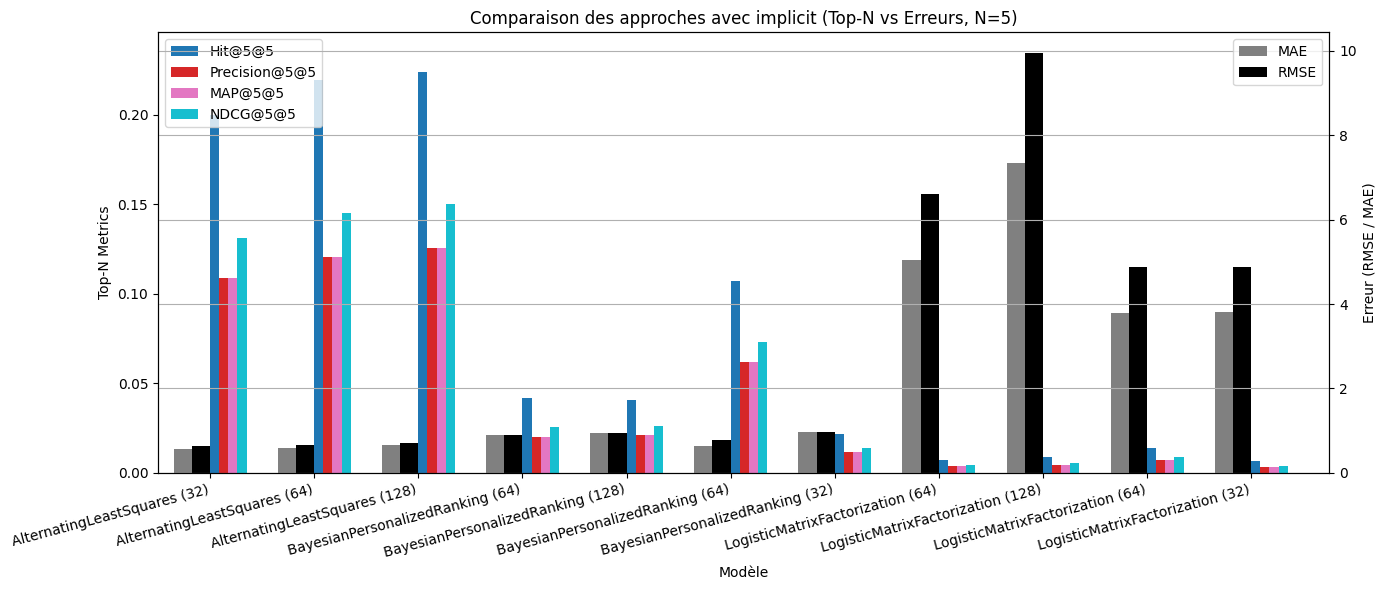

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Copie pour modifications
df_results = df_grid_results.copy()

# Créer une colonne "main_param" avec 'factors' ou 'K'
df_results["main_param"] = (
    df_results.get("factors", np.nan)
    .fillna(df_results.get("K", np.nan))
    .fillna("NA")
    .astype("Int64")
    .astype(str)
)

# Créer une colonne "Approche" pour l'affichage
df_results["Approche"] = df_results["model"] + " (" + df_results["main_param"] + ")"
df_results.set_index("Approche", inplace=True)

# Détecter dynamiquement les métriques Top-N et erreurs
topn_metrics = [col for col in df_results.columns if col.upper().startswith(("HIT@", "MAP@", "NDCG@", "PRECISION@"))]
error_metrics = [col for col in df_results.columns if col.upper() in ["RMSE", "MAE"]]

# Créer la figure
fig, ax1 = plt.subplots(figsize=(14, 6))

# Barres Top-N
df_results[topn_metrics].plot(kind='bar', ax=ax1, position=0, width=0.35, colormap='tab10')
ax1.set_ylabel("Top-N Metrics")

topn_max = df_results[topn_metrics].max().max()
ax1.set_ylim(0, max(0.0005, topn_max * 1.1))
ax1.set_xlabel("Modèle")
ax1.set_xticklabels(df_results.index, rotation=15, ha='right')
ax1.legend(loc='upper left')

# Barres Erreur (axe secondaire)
ax2 = ax1.twinx()
df_results[error_metrics].plot(kind='bar', ax=ax2, position=1, width=0.35, color=["gray", "black"])
ax2.set_ylabel("Erreur (RMSE / MAE)")
ax2.legend(loc='upper right')

# Ajustements
ax1.set_xlim(-0.5, len(df_results) - 0.25)
plt.title("Comparaison des approches avec implicit (Top-N vs Erreurs, N={})".format(N))
plt.grid(True)
plt.tight_layout()
plt.show()
